#
# **Strategy Testing**

This notebook implements a strategy testing framework for SPY (S&P 500 ETF) using volatility-based signals. Below is an outline of the main sections:

## 1. Introduction and Setup
Importing necessary libraries such as `yfinance`, `pandas`, `arch`, and configuring `matplotlib` for dark-themed visualizations.

## 2. Data Preparation
- Historical SPY data is fetched using the `yfinance` API.
- Logarithmic returns are calculated.
- A DataFrame is initialized to store returns, rolling volatility forecasts, and regime classifications.

## 3. Volatility Forecasting and Regime Classification
- A GARCH(2,1) model is used to forecast daily volatility based on a rolling lookback period.
- Market regimes are classified into categories: "Low Vol," "Normal Vol," "High Vol," and "Crisis," using volatility percentiles.
- Position sizes for the strategy are assigned based on the identified regime.

## 4. Portfolio Strategy Implementation
- A trading strategy is simulated, tracking equity growth under different regimes.
- Transaction costs (commissions) are calculated for changes in position size.
- Strategy performance is compared against a simple buy-and-hold approach.

## 5. Performance Metrics
Key metrics are calculated to evaluate the strategy:
- **Total Return**: Returns achieved by the strategy vs. buy-and-hold.
- **Annual Volatility**: Risk measured as standard deviation of returns.
- **Sharpe Ratio**: Risk-adjusted return.
- **Max Drawdown**: Largest peak-to-trough equity decline.
- **Commissions**: Total transaction costs incurred.

## 6. Visualization
The final section includes visualizations for equity curves and forecasted volatility trends to illustrate the strategy's performance against buy & hold benchmark and regime behavior.

##


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = '#333333'
plt.rcParams['axes.facecolor'] = '#333333'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = '#444444'

In [2]:
INITIAL_CAPITAL = 10000

start_date='2019-01-01'
end_date = "2025-01-01"
spy = yf.download('SPY', start=start_date, end=end_date)
spy_returns = 100 * np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))
# Drop missing values (from the shift operation)
spy_returns = spy_returns.dropna()

[*********************100%***********************]  1 of 1 completed


In [3]:
lookback_period=125

def forecast_volatility(returns, lookback=lookback_period):
    """
    Forecast next day volatility using optimized GARCH model
    """
    if len(returns) < lookback:
        return None
    
    # Use the lookback period for fitting
    train_returns = returns[-lookback:]
    
    # Fit GARCH model
    model = arch.arch_model(train_returns, mean='constant', vol='GARCH', p=2, q=1, dist='skewstudent')
    results = model.fit(disp='off', show_warning=False)
    
    # Get forecast for next day
    forecast = results.forecast(horizon=1)
    
    return np.sqrt(forecast.variance.values[-1][0])

In [4]:
from pandas.tseries.holiday import USFederalHolidayCalendar

def get_extended_date(star_date, back_period):
    """
    Calculates the exact date, N trading days prior to a given date
    """
    # Create a custom business day offset that considers US federal holidays
    custom_bday = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
    biz_days_prior_hol = star_date - custom_bday * back_period

    return biz_days_prior_hol.date()

## Core strategy development

In [5]:
# Calculate the extended dfs
extended_date = get_extended_date(datetime.strptime(start_date, '%Y-%m-%d'), lookback_period).strftime('%Y-%m-%d')
extended_spy = yf.download('SPY', start=extended_date, end=end_date)
extended_spy_returns = 100 * np.log(extended_spy['Adj Close'] / extended_spy['Adj Close'].shift(1))
extended_spy_returns = extended_spy_returns.dropna()

# Initialize DataFrame for forecasts and regime classification
portfolio = pd.DataFrame(index=spy_returns.index)
portfolio['SPY_Returns'] = spy_returns
portfolio['Forecast_Vol'] = np.nan
portfolio['Regime'] = 'Normal Vol'

# Calculate rolling volatility forecasts
for i in range(len(portfolio)):
    if i < lookback_period:  
        returns_slice = extended_spy_returns.iloc[:lookback_period+ i+1]
        forecast = forecast_volatility(returns_slice)
        if forecast is not None:
            portfolio['Forecast_Vol'].iloc[i] = forecast
    else:
        returns_slice = spy_returns.iloc[:i+1]
        forecast = forecast_volatility(returns_slice)
        if forecast is not None:
            portfolio['Forecast_Vol'].iloc[i] = forecast

# Calculate regime thresholds based on historical forecasts
valid_forecasts = portfolio['Forecast_Vol'].dropna()
vol_25th = np.percentile(valid_forecasts, 25)
vol_75th = np.percentile(valid_forecasts, 75)
vol_90th = np.percentile(valid_forecasts, 90)

# Classify regimes based on forecasted volatility
portfolio.loc[portfolio['Forecast_Vol'] < vol_25th, 'Regime'] = 'Low Vol'
portfolio.loc[portfolio['Forecast_Vol'] > vol_75th, 'Regime'] = 'High Vol'
portfolio.loc[portfolio['Forecast_Vol'] > vol_90th, 'Regime'] = 'Crisis'

# Set position sizes based on regime
portfolio['SPY_Long_Position'] = np.where(portfolio['Regime'] == 'Low Vol', 1.0,
                                np.where(portfolio['Regime'] == 'Normal Vol', 1.0,
                                np.where(portfolio['Regime'] == 'High Vol', 0.75, 0.0)))

portfolio['SPY_Short_Position'] = np.where(portfolio['Regime'] == 'High Vol', -0.1,
                                 np.where(portfolio['Regime'] == 'Crisis', -0.5, 0.0))

# Calculate net SPY position
portfolio['Net_SPY_Position'] = portfolio['SPY_Long_Position'] + portfolio['SPY_Short_Position']

# Initialize equity tracking
portfolio['Strategy_Equity'] = INITIAL_CAPITAL
portfolio['Buy_Hold_Equity'] = INITIAL_CAPITAL

# Initialize equity tracking and commission columns_
portfolio['Strategy_Equity'] = INITIAL_CAPITAL
portfolio['Buy_Hold_Equity'] = INITIAL_CAPITAL
portfolio['Daily_Commission'] = 0.0
portfolio['Cumulative_Commission'] = 0.0

[*********************100%***********************]  1 of 1 completed


### Calculates dollar returns and equity

In [6]:
for i in range(1, len(portfolio)):
    # Previous day's equity
    prev_strategy_equity = portfolio['Strategy_Equity'].iloc[i-1]
    prev_buy_hold_equity = portfolio['Buy_Hold_Equity'].iloc[i-1]
    
    # Calculate transaction costs (0.1% of traded value when position changes)
    position_change = abs(portfolio['Net_SPY_Position'].iloc[i] - portfolio['Net_SPY_Position'].iloc[i-1])
    commission = prev_strategy_equity * 0.001 * position_change
    
    # Record daily commission
    portfolio.loc[portfolio.index[i], 'Daily_Commission'] = commission
    
    # Update cumulative commission
    portfolio.loc[portfolio.index[i], 'Cumulative_Commission'] = (portfolio['Daily_Commission'].iloc[:i+1].sum())
    
    # Calculate strategy returns in dollars
    strategy_return_pct = portfolio['Net_SPY_Position'].iloc[i] * portfolio['SPY_Returns'].iloc[i] / 100
    strategy_dollar_return = prev_strategy_equity * strategy_return_pct
    
    # Update strategy equity (subtracting commission)
    portfolio.loc[portfolio.index[i], 'Strategy_Equity'] = (prev_strategy_equity + strategy_dollar_return - commission)
    
    # Calculate buy & hold returns in dollars_

    buy_hold_return_pct = portfolio['SPY_Returns'].iloc[i] / 100
    buy_hold_dollar_return = prev_buy_hold_equity * buy_hold_return_pct
    
    # Update buy & hold equity
    portfolio.loc[portfolio.index[i], 'Buy_Hold_Equity'] = (prev_buy_hold_equity + buy_hold_dollar_return)

### Calculates performance metrics

In [7]:
strategy_returns = portfolio['Strategy_Equity'].pct_change().dropna()
buy_hold_returns = portfolio['Buy_Hold_Equity'].pct_change().dropna()

risk_free_rate_annual = 0.03  
risk_free_rate_daily = risk_free_rate_annual / 252
excess_returns = strategy_returns - risk_free_rate_daily

performance_metrics = {
    'Initial_Capital': INITIAL_CAPITAL,
    'Final_Strategy_Equity': portfolio['Strategy_Equity'].iloc[-1],
    'Final_Buy_Hold_Equity': portfolio['Buy_Hold_Equity'].iloc[-1],
    'Total_Commissions': portfolio['Cumulative_Commission'].iloc[-1],
    'Total_Return': (portfolio['Strategy_Equity'].iloc[-1] / INITIAL_CAPITAL - 1),
    'Buy_Hold_Return': (portfolio['Buy_Hold_Equity'].iloc[-1] / INITIAL_CAPITAL - 1),
    'Annual_Return': strategy_returns.mean() * 252,
    'Annual_Volatility': strategy_returns.std() * np.sqrt(252),
    'Sharpe_Ratio': excess_returns.mean() / excess_returns.std(),
    'Max_Drawdown': (portfolio['Strategy_Equity'] / 
                    portfolio['Strategy_Equity'].cummax() - 1).min(),
}

regime_counts = portfolio['Regime'].value_counts()

## Equity Curves and Volatility visualization

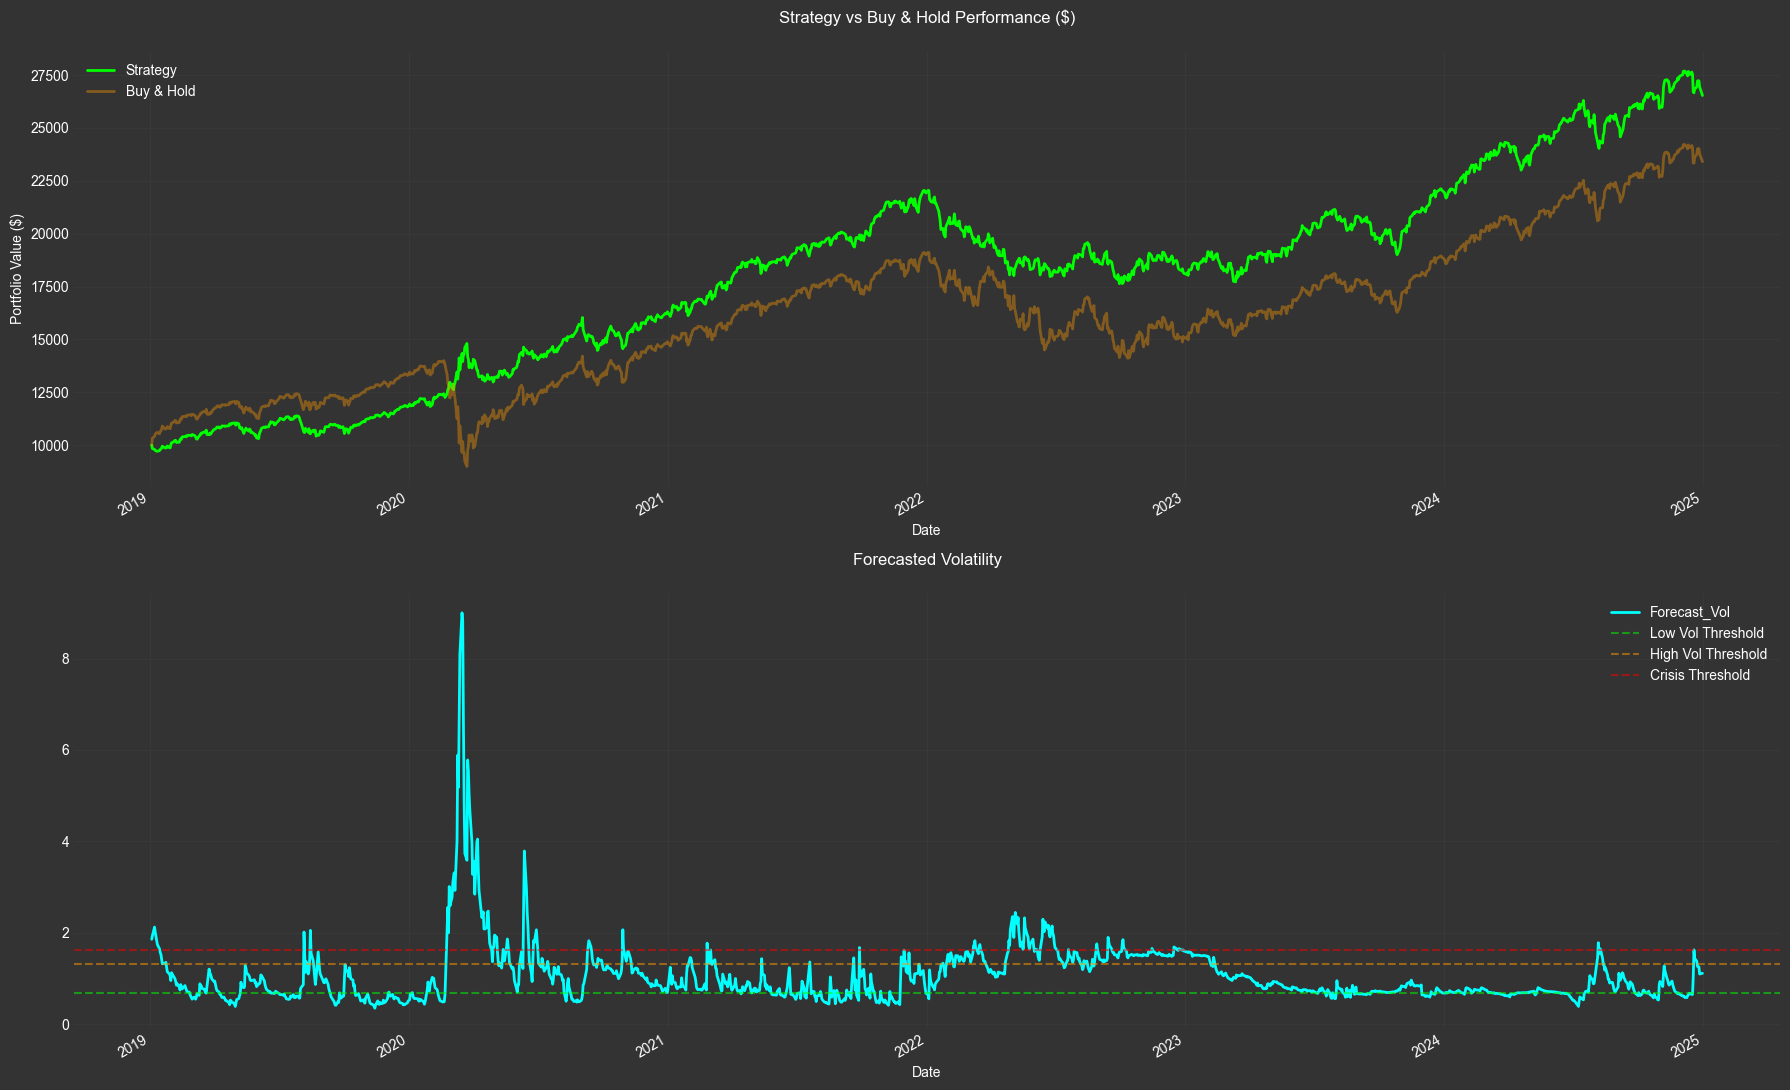

In [8]:
plt.figure(figsize=(18, 11))

# Plot 1: Equity Curves
ax1 = plt.subplot(2, 1, 1)
portfolio['Strategy_Equity'].plot(label='Strategy', color='#00ff00', linewidth=2)
portfolio['Buy_Hold_Equity'].plot(label='Buy & Hold', color='#ff9900', linewidth=2, alpha=0.4)
plt.title('Strategy vs Buy & Hold Performance ($)', pad=20)
plt.legend(facecolor='#333333', edgecolor='white')
plt.grid(True, alpha=0.3)
plt.ylabel('Portfolio Value ($)')

# Plot 2: Forecasted Volatility
ax2 = plt.subplot(2, 1, 2)
portfolio['Forecast_Vol'].plot(color='#00ffff', linewidth=2)
plt.axhline(y=vol_25th, color='#00ff00', linestyle='--', alpha=0.5, label='Low Vol Threshold')
plt.axhline(y=vol_75th, color='#ff9900', linestyle='--', alpha=0.5, label='High Vol Threshold')
plt.axhline(y=vol_90th, color='#ff0000', linestyle='--', alpha=0.5, label='Crisis Threshold')
plt.title('Forecasted Volatility', pad=20)
plt.legend(facecolor='#333333', edgecolor='white')
plt.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

## Performance metrics

In [9]:
print("\nPerformance Metrics:")
for metric, value in performance_metrics.items():
    if metric in ['Initial_Capital', 'Final_Strategy_Equity', 'Final_Buy_Hold_Equity', 'Total_Commissions']:
        print(f"{metric}: ${value:,.2f}")
    else:
        print(f"{metric}: {value:.2%}")

# Print regime distribution
print("\nRegime Distribution:")
print(regime_counts)

# Print average position sizes by regime
print("\nAverage Position Sizes by Regime:")
print(portfolio.groupby('Regime')[['Net_SPY_Position']].mean())

# Get the latest forecast for next day
latest_returns = spy_returns[-lookback_period:]
next_day_forecast = forecast_volatility(latest_returns)

# Print next day forecast
print("\nNext Day Forecast:")
print(f"Forecasted Volatility: {next_day_forecast:.4f}")
current_regime = 'Normal Vol'
if next_day_forecast < vol_25th:
    current_regime = 'Low Vol'
elif next_day_forecast > vol_90th:
    current_regime = 'Crisis'
elif next_day_forecast > vol_75th:
    current_regime = 'High Vol'
print(f"Implied Regime: {current_regime}")
print(f"Current Portfolio Value: ${portfolio['Strategy_Equity'].iloc[-1]:,.2f}")


Performance Metrics:
Initial_Capital: $10,000.00
Final_Strategy_Equity: $26,533.68
Final_Buy_Hold_Equity: $23,404.57
Total_Commissions: $1,603.74
Total_Return: 165.34%
Buy_Hold_Return: 134.05%
Annual_Return: 17.32%
Annual_Volatility: 14.19%
Sharpe_Ratio: 6.36%
Max_Drawdown: -20.01%

Regime Distribution:
Regime
Normal Vol    755
Low Vol       377
High Vol      226
Crisis        151
Name: count, dtype: int64

Average Position Sizes by Regime:
            Net_SPY_Position
Regime                      
Crisis                 -0.50
High Vol                0.65
Low Vol                 1.00
Normal Vol              1.00

Next Day Forecast:
Forecasted Volatility: 1.1143
Implied Regime: Normal Vol
Current Portfolio Value: $26,533.68


## Portfolio df first/last rows

In [10]:
portfolio[['Strategy_Equity', 'Buy_Hold_Equity', 'Cumulative_Commission']] = portfolio[['Strategy_Equity', 'Buy_Hold_Equity', 'Cumulative_Commission']].round(2)
pd.concat([portfolio.head(1), portfolio.tail(1)])

,SPY_Returns,Forecast_Vol,Regime,SPY_Long_Position,SPY_Short_Position,Net_SPY_Position,Strategy_Equity,Buy_Hold_Equity,Daily_Commission,Cumulative_Commission
Date,,,,,,,,,,
2019-01-03,-2.415206,1.860289,Crisis,0.0,-0.5,-0.5,10000.00,10000.00,0.0,0.00
2024-12-31,-0.364465,1.114303,Normal Vol,1.0,0.0,1.0,26533.68,23404.57,0.0,1603.74
